In [1]:
import helper_funcs as hlp

import pickle
import numpy as np
from time import time
import matplotlib.pyplot as plt  
from sklearn.svm import SVC
from pytket.extensions.qiskit import AerBackend

from discopy.quantum import Circuit, Id, Measure, qubit, Bra
from pytket.extensions.qiskit import tk_to_qiskit, AerBackend, IBMQBackend, IBMQEmulatorBackend


In [2]:
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'n_shots': 2**13,
}

train_labels, train_data = hlp.read_data('mc_train_data.txt')
test_labels, test_data = hlp.read_data('mc_test_data.txt')

embedding = hlp.load_weights('trained_embeddings_new.pkl')
vocab = embedding['vocab']
vals = embedding['vals']

In [3]:
test_circs = hlp.build_circuits(test_data)
test_pred_fn = hlp.make_pred_fn(test_circs, vocab, backend_config=backend_config)
test_cost_fn, _, test_accs = hlp.make_cost_fn(test_pred_fn, test_labels)
test_cost_fn(vals)
print(f'Test accuracy: {test_accs[-1]}')

Test accuracy: 0.9


In [4]:
x_circs = hlp.build_circuits(train_data)
y_circs = hlp.build_circuits(test_data)

In [5]:
x_circs = [c.lambdify(*vocab)(*vals) for c in x_circs]
y_circs = [c.lambdify(*vocab)(*vals) for c in y_circs]

## Kernelize

In [6]:
type(x_circs[0])

discopy.quantum.circuit.Circuit

In [106]:
x = x_circs[0]
y = y_circs[0]

In [107]:
seed = 123

"""New implementation of transition amplitude sim"""
def fn(x_circ, y_circ):
    sim_circ = x_circ >> y_circ.dagger()
    return Circuit.eval(sim_circ, **backend_config, seed=seed).array[0]

In [108]:
s = x >> x.dagger()
s_tk = s.to_tk() 

In [109]:
xd = x.dagger()
xd

Circuit(dom=qubit, cod=Ty(), boxes=[Ket(0, 0), H, H, SWAP, CRz(-1.64), SWAP, Rx(-1.04), Rz(-0.236), Rx(1.14), Bra(0), Ket(0), Rx(-1.32), Rz(-0.261), Rx(0.685), CRz(-0.402), CRz(1.16), H, H, H, Bra(0, 0, 0)], offsets=[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 0, 2, 1, 0, 0])

In [110]:
d = xd.dom
c = xd.cod
boxes = xd.boxes
offsets = xd.offsets

In [114]:
from discopy.quantum.gates import Ket, Bra, Id

In [123]:
qubit_dict = {}
for i in range(len(boxes)):
    box = boxes[i]
    if isinstance(box, Ket):
        for q in range(len(box.cod)):
            qubit_dict[q + offsets[i]] = 1
            
skip_indices = [i for i in range(4) if i not in qubit_dict]
skip_idx = skip_indices[0]

boxes_new = []
offsets_new=  []
for i in range(len(boxes)):
    if isinstance(boxes[i], Bra):
        for offset in range(offsets[i], offsets[i]+len(boxes[i].dom)):
            if offset != skip_idx:
                boxes_new.append(Bra(0))
                offsets_new.append(offset)
            else:
                boxes_new.append(Id(0))
                offsets_new.append(offset)
    else:
        boxes_new.append(boxes[i])
        offsets_new.append(offsets[i])

boxes_new = boxes[:-1]
offsets_new = offsets[:-1]

In [124]:
print(boxes)
print(offsets)

[Ket(0, 0), H, H, SWAP, CRz(-1.64), SWAP, Rx(-1.04), Rz(-0.236), Rx(1.14), Bra(0), Ket(0), Rx(-1.32), Rz(-0.261), Rx(0.685), CRz(-0.402), CRz(1.16), H, H, H, Bra(0, 0, 0)]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 0, 2, 1, 0, 0]


In [125]:
print(boxes_new)
print(offsets_new)

[Ket(0, 0), H, H, SWAP, CRz(-1.64), SWAP, Rx(-1.04), Rz(-0.236), Rx(1.14), Bra(0), Ket(0), Rx(-1.32), Rz(-0.261), Rx(0.685), CRz(-0.402), CRz(1.16), H, H, H]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 0, 2, 1, 0]


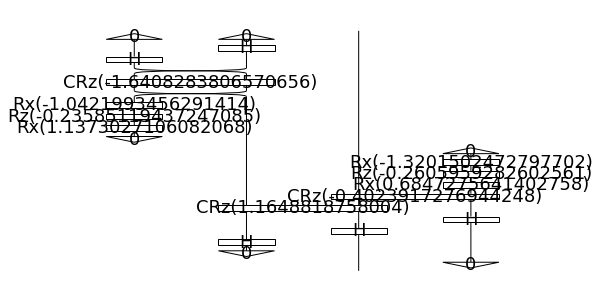

In [139]:
a = Circuit(d,d@d@d,boxes_new,offsets_new)
a = a >> Bra(0) @ Id(1) @ Bra(0)
a.draw()


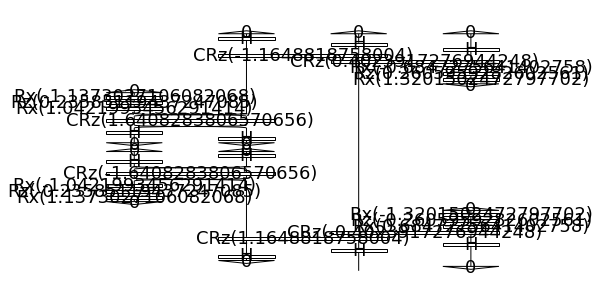

In [151]:
s = x >> a
s.draw()

In [158]:
tk_s

tk.Circuit(7, 6).TK1(3.859171619342934, 3.5, 3.5, 0).TK1(0.0, 1.5, 3.5, 1).TK1(1.184868130022807, 0.27671812178696115, 0.8890013677869422, 2).TK1(0.0, 1.5, 3.5, 3).TK1(0.33511812419959996, 3.5, 3.5, 4).TK1(3.974579697287306, 0.42766848808254154, 2.388418025220641, 5).TK1(1.9023917276944249, 3.5, 3.5, 6).CX(1, 0).CX(3, 4).TK1(0.0, 1.9156013087417172, 1.6408283806570658, 0).TK1(0.0, 0.0, 1.1648818758004, 4).CX(1, 0).CX(3, 4).TK1(0.0, 2.2746054212164135, 3.5282976112550584, 0).CX(3, 2).TK1(0.0, 0.0, 1.1648818758004, 4).Measure(0, 3).TK1(0.0, 0.0, 2.359171619342934, 2).CX(4, 6).CX(3, 2).TK1(0.0, 2.630544871719448, 3.597608272305575, 6).TK1(0.5, 0.5, 0.5, 2).TK1(0.5, 0.5, 0.0, 3).CX(4, 6).Measure(2, 1).Measure(3, 2).CX(4, 5).TK1(0.0, 2.6403004945595403, 0.5211918565205123, 6).Measure(6, 0).TK1(0.0, 0.0, 0.4023917276944248, 5).CX(4, 5).CX(1, 4).TK1(0.5, 0.5, 0.5, 5).Measure(5, 5).TK1(0.0, 0.0, 2.8351181241996, 4).CX(1, 4).TK1(0.5, 0.5, 0.0, 1).TK1(0.5, 0.5, 0.5, 4).Measure(1, 4).post_select(

In [147]:
tk_s = s.to_tk()

In [164]:
res = tk_s.get_counts(**backend_config, seed=seed, measure_all=True)

In [165]:
total_p = sum(res[0].values())
res = {k : p/total_p for k, p in res[0].items()}

In [166]:
res

{(0,): 0.9664429530201343, (1,): 0.03355704697986577}

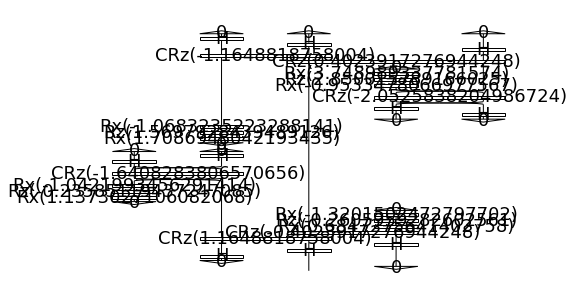

In [167]:
s = y >> a
s.draw()

In [168]:
tk_s = s.to_tk()
res = tk_s.get_counts(**backend_config, seed=seed, measure_all=True)

total_p = sum(res[0].values())
res = {k : p/total_p for k, p in res[0].items()}
res

{(0,): 0.9622641509433962, (1,): 0.03773584905660377}

In [176]:
r = []
for c in x_circs:
    s = c >> a
    tk_s = s.to_tk()
    res = tk_s.get_counts(**backend_config, seed=seed, measure_all=True)

    total_p = sum(res[0].values())
    res = {k : p/total_p for k, p in res[0].items()}
    r.append(res[(0,)])

In [177]:
r

[0.9664429530201343,
 0.9279279279279279,
 1.0,
 0.7938388625592417,
 0.12903225806451613,
 0.9574468085106383,
 0.16111111111111112,
 0.08433734939759036,
 0.9464285714285714,
 0.9259259259259259,
 1.0,
 0.9166666666666666,
 0.8432835820895522,
 0.13861386138613863,
 0.989769820971867,
 0.9863013698630136,
 0.5387596899224806,
 0.05238095238095238,
 0.9976359338061466,
 0.17721518987341772,
 0.12162162162162163,
 0.14423076923076922,
 0.2727272727272727,
 0.12719298245614036,
 0.7333333333333333,
 0.33980582524271846,
 0.882051282051282,
 0.875968992248062,
 0.682648401826484,
 0.30303030303030304,
 0.5958549222797928,
 0.9770992366412213,
 0.8787878787878788,
 0.7604166666666666,
 0.9096045197740112,
 0.125,
 0.1566265060240964,
 0.5357142857142857,
 0.06382978723404255,
 0.7368421052631579,
 0.8578431372549019,
 0.9942363112391931,
 0.90633608815427,
 0.9932279909706546,
 0.9110576923076923,
 0.9142857142857143,
 0.049079754601226995,
 0.0893854748603352,
 0.08333333333333333,
 0.99

In [179]:
train_labels[:, 0]

array([1, 1, 1, ..., 0, 1, 0])

In [184]:
r2 = np.array(r)
1 - np.sum(np.abs(r2.round() - train_labels[:, 0])) / len(r2)

0.9285714285714286

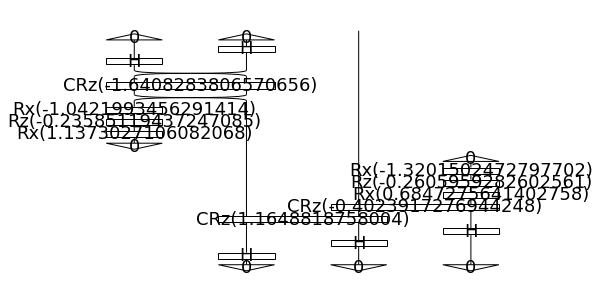

In [186]:
x_circs[0].dagger().draw()

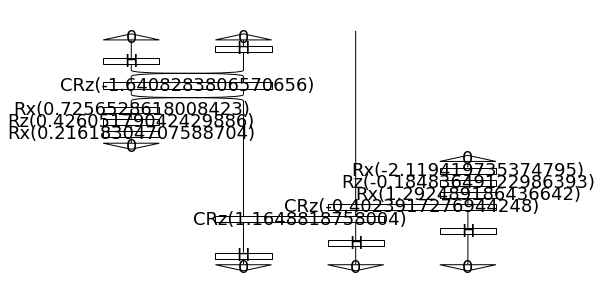

In [235]:
x_circs[10].dagger().draw()

In [216]:
xd = x_circs[2].dagger()
d = xd.dom
c = xd.cod
boxes = xd.boxes
offsets = xd.offsets

new_b = []
new_o = []
for i in range(len(boxes)):
    if not isinstance(boxes[i], Bra):
        new_b.append(boxes[i])
        new_o.append(offsets[i])
    else:
        if len(boxes[i].dom) == 1:
            new_b.append(boxes[i])
            new_o.append(offsets[i])
            
        


In [219]:
print(boxes)
print(offsets)

[Ket(0), Rx(-1.71), Rz(-1.57), Rx(1.07), Ket(0, 0), H, H, SWAP, CRz(2.05), SWAP, Rx(1.29), Rz(-0.185), Rx(-2.12), Bra(0), CRz(0.555), CRz(-3.28), H, H, H, Bra(0, 0, 0)]
[0, 0, 0, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 0, 0]


In [217]:
print(new_b)
print(new_o)

[Ket(0), Rx(-1.71), Rz(-1.57), Rx(1.07), Ket(0, 0), H, H, SWAP, CRz(2.05), SWAP, Rx(1.29), Rz(-0.185), Rx(-2.12), Bra(0), CRz(0.555), CRz(-3.28), H, H, H]
[0, 0, 0, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 0]


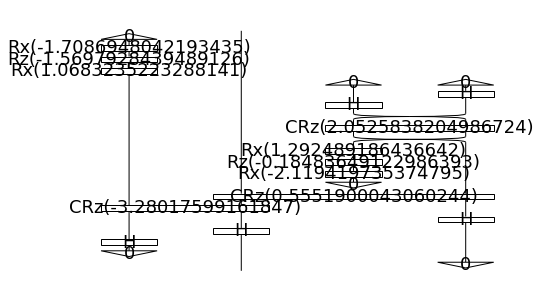

In [222]:
q = Circuit(d, d@d@d, new_b, new_o)
q = q >> Bra(0) @ Id(1) @ Bra(0)
q.draw()

In [227]:
r = []
for c in y_circs:
    s = c >> a
    tk_s = s.to_tk()
    res = tk_s.get_counts(**backend_config, seed=seed, measure_all=True)

    total_p = sum(res[0].values())
    res = {k : p/total_p for k, p in res[0].items()}
    r.append(res.get((0,), 0))
   
r2 = np.array(r)
1 - np.sum(np.abs(r2.round() - test_labels[:, 0])) / len(r2)

0.9333333333333333

In [251]:
def get_new_fun(backend_config, seed):
    """New implementation of transition amplitude sim"""
    def trans_amp_sim(x_circ, y_circ):
        yd = y_circ.dagger()

        d = yd.dom
        c = yd.cod
        boxes = yd.boxes
        offsets = yd.offsets

        new_b = []
        new_o = []
        for i in range(len(boxes)):
            if not isinstance(boxes[i], Bra):
                new_b.append(boxes[i])
                new_o.append(offsets[i])
            else:
                if len(boxes[i].dom) == 1:
                    new_b.append(boxes[i])
                    new_o.append(offsets[i])

        yd_new = Circuit(d, d@d@d, new_b, new_o)
        yd_new = yd_new >> Bra(0) @ Id(1) @ Bra(0)

        kernel = x_circ >> yd_new
        tk_kernel = kernel.to_tk()
        res = tk_kernel.get_counts(**backend_config, seed=seed, measure_all=True)

        total_p = sum(res[0].values())
        res = {k : p/total_p for k, p in res[0].items()}
        return res.get((0,), 0)
    return trans_amp_sim

In [246]:
r = []
for x in x_circs:
    r.append(trans_amp_sim(x, x))

In [10]:
kernel = hlp.make_kernel_fn(vocab, vals, backend_config={},
                           get_sim_fn=hlp.get_transition_amp_sim_fn)
kernel(train_data[0], train_data[0])

Took 0.619 s to prep circs
Took 0.055 s to build matrix


array([[0.13262865]])

In [12]:
gram_train, gram_test = hlp.build_gram_matrices(
    train_data, test_data, vocab, vals, backend_config={}, get_sim_fn=hlp.get_transition_amp_sim_fn
)

Building circuits...


Took 12.384 s 
Building training Gram matrix...
Took 86.94 s 
Building testing Gram matrix...
Took 74.513 s 


In [ ]:
save_name = ''
if save_name:
    np.save(f'{save_name}_test.npy', gram_test)
    np.save(f'{save_name}_train.npy', gram_train)

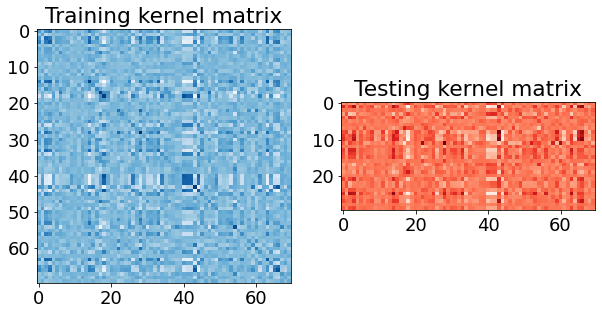

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(gram_train), interpolation="nearest", origin="upper", cmap="Blues")
axs[0].set_title("Training kernel matrix")
axs[1].imshow(np.asmatrix(gram_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")

# plt.savefig(f'kernel_mats-qasm.pdf', dpi=1200, bbox_inches="tight")
plt.show()

In [14]:
svc = SVC(kernel="precomputed")

ts = time()
svc.fit(gram_train, train_labels[:, 0])
hlp.timestamp(time(), ts, 'to fit SVC')

ts = time()
score = svc.score(gram_test, test_labels[:, 0])
hlp.timestamp(time(), ts, 'to score SVC')

print(f"Precomputed kernel classification test score: {score}")

Took 2.029 s to fit SVC
Took 0.052 s to score SVC
Precomputed kernel classification test score: 0.5


## Grouping

In [6]:
def sort_data(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    
    is_class_0 = y[:, 0] == 0
    sorted_x = np.concatenate([x[is_class_0], x[~is_class_0]])
    sorted_y = np.concatenate([y[is_class_0], y[~is_class_0]])
    return sorted_x, sorted_y

In [7]:
train_labels, train_data = hlp.read_data('mc_train_data.txt')
test_labels, test_data = hlp.read_data('mc_test_data.txt')

train_data, train_labels = hlp.sort_data(train_data, train_labels)
test_data, test_labels = hlp.sort_data(test_data, test_labels)

In [ ]:
gram_train, gram_test = hlp.build_gram_matrices(
    train_data, test_data, vocab, vals, backend_config=backend_config, 
    sim_fn=hlp.transition_amp_sim_fn
)

hlp.display_grams(gram_train, gram_test)

Building circuits...


Took 7.376 s 
Building training Gram matrix...


In [ ]:
svc = SVC(kernel="precomputed")

ts = time()
svc.fit(gram_train, train_labels[:, 0])
hlp.timestamp(time(), ts, 'to fit SVC')

ts = time()
score = svc.score(gram_test, test_labels[:, 0])
hlp.timestamp(time(), ts, 'to score SVC')

print(f"Precomputed kernel classification test score: {score}")

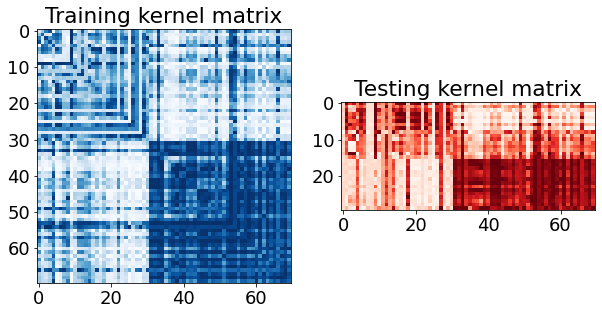

In [254]:
hlp.display_grams(gram_train, gram_test, save_name='figs/transition-amp-gram_0.766')

In [255]:
gram_train, gram_test = hlp.build_gram_matrices(
    train_data, test_data, vocab, vals, backend_config=backend_config, get_sim_fn=hlp.get_swap_test_fn
)

hlp.display_grams(gram_train, gram_test)

Building circuits...


Took 127.659 s 
Building training Gram matrix...


KeyboardInterrupt: 

In [ ]:
hlp.display_grams(gram_train, gram_test, save_name='figs/swap-test-gram_0.933')